# 1. Problem

### <h2> 1.1 Description </h2>

<p>In computer vision​, Image segmentation is the process of partitioning a digital image into multiple segments. The goal of segmentation is to  simplify and/or change the representation of an image into something  that is more meaningful and easier to analyze.</p>
<p> Indian Driving Dataset is a novel dataset for road scene understanding  in unstructured environments. Unstructured environments usually  corresponds to well-delineated infrastructure such as lanes, a small  number of well-defined categories for traffic participants, low variation  in object or background appearance and strong adherence to traffic  rules.  </p>
<p></p>
<p></p>

### <h2> 1.2 Sources for the data</h2>


- Source : https://idd.insaan.iiit.ac.in/

# 2. Data

<h3> 2.1 Data Overview </h3>

- Indian Driving Dataset ​consists of 10,000 images, finely annotated with  34 classes collected from 182 drive sequences on Indian roads.
- The dataset consists of images obtained from a front facing camera  attached to a car. The car was driven around Hyderabad, Bangalore  cities and their outskirts.  
- This project would be implemented on IDD Lite dataset (2000 Entries) which  contains 7 classes compared to 30 in IDD due to restricted computing resources
- The 7 classes in IDD Lite dataset are :  
● drivable - 0  
● non-drivable - 1  
● living-thing - 2  
● 2-Wheeler, autorickshaw, large-vehicle - 3  
● barrier, structures - 4  
● construction - 5  
● vegetation , sky -6 

<h3> 2.2. Performance Metric </h3>
- The performance metric would be mIoU - Mean Intersection Over  Union also known as Jaccard Index. The mean IoU of the image is  calculated by taking the IoU of each class and averaging them.

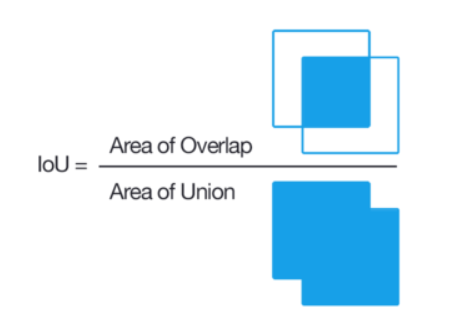


# 1. Loading the data

# 0. Import dependencies

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,concatenate,Input,LSTM, Reshape,Permute
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Conv1D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization


from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import he_normal
from time import time
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

import os
import numpy as np
import cv2
import torch

In [ ]:
root = '/kaggle/input/cv-class-dataset-exploded/' 
data = root + 'idd20k_lite1/'

img_train = data + 'leftImg8bit/train/'
seg_train = data + 'gtFine/train/'

img_test = data + 'leftImg8bit/val/'
seg_test = data + 'gtFine/val/'

In [ ]:
img_train_files = sorted(os.listdir(img_train))
seg_train_files = sorted(os.listdir(seg_train))
img_test_files = sorted(os.listdir(img_test))
seg_test_files = sorted(os.listdir(seg_test))

In [ ]:
train_img = os.listdir(img_train)
train_img.sort()
train_seg = os.listdir(seg_train)
train_seg.sort()

test_img = os.listdir(img_test)
test_img.sort()
test_seg = os.listdir(seg_test)
test_seg.sort()

<li> The label images are of 2 types,semantic segementation and instance segmentation

In [ ]:
# separating semantic and instance segmentation labels
train_seg_label=[]
train_inst_seg=[]
for i in range(1,len(train_seg)):
    if(i%2 !=0):
        train_seg_label.append(train_seg[i])
    else:
        train_inst_seg.append(train_seg[i])

test_seg_label=[]
test_inst_seg=[]
for i in range(len(test_seg)):
    if(i%2 !=0):
        test_seg_label.append(test_seg[i])
    else:
        test_inst_seg.append(test_seg[i])

In [ ]:
print(train_img[:5])
print(train_seg_label[:5])
print(test_img[:5])
print(test_seg_label[:5])

In [ ]:
for i in range(len(train_img)):
    first_img = cv2.imread(root + 'idd20k_lite1/leftImg8bit/train/'+train_img[0])
    img = cv2.imread(root + 'idd20k_lite1/leftImg8bit/train/'+train_img[i])
    if(first_img.shape == img.shape):
        if(i==len(train_img)-1):
            print('Number of train Images =',len(train_img))
            print('All Train Images have same shape')
            print('Shape of all Train images =',img.shape)
        continue
    else:
        print(train_img[i]+' has shape :',img.shape)
print('='*80)

for i in range(len(train_seg_label)):
    first_img = cv2.imread(root + 'idd20k_lite1/gtFine/train/'+train_seg_label[0])
    img = cv2.imread(root + 'idd20k_lite1/gtFine/train/'+train_seg_label[i])
    if(first_img.shape == img.shape):
        if(i==len(train_img)-1):
            print('Number of train labels =',len(train_seg_label))
            print('All Train Labels have same shape')
            print('Shape of all Train Labels =',img.shape)
        continue
    else:
        print(train_seg_label[i]+' has shape :',img.shape)
print('='*80)

for i in range(len(test_img)):
    first_img = cv2.imread(root + 'idd20k_lite1/leftImg8bit/val/'+test_img[0])
    img = cv2.imread(root + 'idd20k_lite1/leftImg8bit/val/'+test_img[i])
    if(first_img.shape == img.shape):
        if(i==len(test_img)-1):
            print('Number of Test Images =',len(test_img))
            print('All Test Images have same shape')
            print('Shape of all Test images =',img.shape)
        continue
    else:
        print(test_img[i]+' has shape :',img.shape)
print('='*80)

In [ ]:
from sklearn.model_selection import train_test_split

# Train and eval split
X_tr,X_cr, y_tr, y_cr = train_test_split(train_img, train_seg_label, test_size=0.25, random_state=15)

In [ ]:
print(X_tr[:5])
print(y_tr[:5])
print(X_cr[:5])
print(y_cr[:5])

In [ ]:
# Resizing image height to 256 beacuse to send as image as inout to uNET model the height and width of the image should
# multiples of 32
height=256
width=320
n_classes=7
def prepare_image_data(path,data):
    src=path+data
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img = np.float32(img)  / 255          #normalization
    return img

# https://github.com/advaitsave/Multiclass-Semantic-Segmentation-CamVid/blob/master/Multiclass%20Semantic%20Segmentation%20using%20U-Net.ipynb
def prepare_label_data(path,data):
    label = np.zeros((height, width, n_classes))
    src=path+data
    img = cv2.imread(src)
    img=cv2.resize(img,(width,height))
    img1=img[:,:,0]
    for i in range(n_classes):
        label[:,:,i] = (img1==i).astype(int)
    return label
    

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

In [ ]:
test_seg_label[:5]

In [ ]:
for i in range(len(X_tr)):
    X_train.append(prepare_image_data(img_train,X_tr[i]))

for i in range(len(y_tr)):
    y_train.append(prepare_label_data(seg_train,y_tr[i]))

for i in range(len(X_cr)):
    X_val.append(prepare_image_data(img_train,X_cr[i]))

for i in range(len(y_cr)):
    y_val.append(prepare_label_data(seg_train,y_cr[i]))

In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_val=np.array(X_val)
y_val=np.array(y_val)

In [ ]:
for i in range(len(test_img)):
    #print(img_test + test_img[i])
    X_test.append(prepare_image_data(img_test,test_img[i]))

for i in range(len(test_seg_label)):
    y_test.append(prepare_label_data(seg_test,test_seg_label[i]))

X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
print('Train Data : ')
print('Images-',X_train.shape)
print('Labels-',y_train.shape)
print('='*40)
print('Validation Data : ')
print('Images-',X_val.shape)
print('Labels-',y_val.shape)
print('='*40)

In [ ]:
len(y_test)

In [ ]:
np.argmax(y_test, axis=3).shape

In [ ]:
tf.keras.backend.clear_session()


In [ ]:
import random as rn
np.random.seed(24)
tf.random.set_seed(28)
rn.seed(12)

In [ ]:
def IoU(y_val, y_pred):
    class_iou = []
    n_classes = 7
    
    y_predi = np.argmax(y_pred, axis=3)
    y_truei = np.argmax(y_val, axis=3)
    
    for c in range(n_classes):
        TP = np.sum((y_truei == c) & (y_predi == c))
        FP = np.sum((y_truei != c) & (y_predi == c))
        FN = np.sum((y_truei == c) & (y_predi != c)) 
        IoU = TP / float(TP + FP + FN)
        if(float(TP + FP + FN) == 0):
          IoU=TP/0.001
        class_iou.append(IoU)
    MIoU=sum(class_iou)/n_classes
    return MIoU

In [ ]:
def miou( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : IoU( y_true, y_pred).astype('float32'),
                        [y_true, y_pred],
                        'float32')
    return score

In [ ]:
"""history_dict = history3.history
print(history_dict.keys())"""

## Model 2 : UNet (with Image augmentation)

In [ ]:
%load_ext tensorboard

# Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2),
  RandomContrast(factor=0.2)
])

In [ ]:
def unet2(pretrained_weights = None):

    inputs = Input(shape=(256, 320,3))
    print(inputs , inputs.shape)
    inputs = data_augmentation(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv4)
    drop4 = Dropout(0.5)(conv4)

    up5 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([conv3,up5], axis = 3)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(merge5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv5)

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv6)

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv7)

    conv8 = Conv2D(7, 3, activation = 'relu', padding = 'same', kernel_initializer = keras.initializers.glorot_normal(seed=24))(conv7)
    out = (Activation('softmax'))(conv8)
  
    model = Model(inputs,out)

    return model

In [ ]:
unet_model2 = unet2()
unet_model2.summary()

In [ ]:
log_dir_4 = os.path.join('unet_model2') 
tensorboard_callback4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir_4) 

In [ ]:
x=X_train.shape[0]//15
x

In [ ]:
checkpoint_path = "checkpoint/unet2cp.ckpt"
os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp2_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
unet_model2.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy',metrics = [miou])

In [ ]:
history4=unet_model2.fit(X_train, y_train,steps_per_epoch=x,epochs=25,verbose=1,
                                  validation_data=(X_val, y_val),callbacks=[tensorboard_callback4, cp2_callback])

In [ ]:
history_dict = history4.history
print(history_dict.keys())

In [ ]:
import matplotlib.pyplot as plt 
loss = history_dict['loss']
val_loss = history_dict['val_loss']
miou = history_dict['miou']
val_miou = history_dict['val_miou']


epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, miou, 'r', label='Training Miou')
plt.plot(epochs, val_miou, 'b', label='Validation Miou')
plt.title('Training and validation Miou')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
%tensorboard --logdir unet_model2


In [ ]:
y_pred = unet_model2.predict(X_val)
print('MIoU for UNet model with Image augmentation is :',IoU(y_val, y_pred))